Author: **Simone Puel** (spuel@utexas.edu) 

Title Manuscript: ***A Mixed, Unified Forward/Inverse Framework for Earthquake Problems: Fault Implementation and Coseismic Slip***

# Coseismic Slip Inversion via Adjoint-based Optimization Methods

Given some discrete, noisy observations $\mathbf{d} \in \mathbb{R}^{n_{obs}}$, we want to infer the unknown model parameter field $m \in \mathcal{M}$ that best reproduces the observations: 

\begin{align}
\mathbf{d} = \mathcal{F}(m) + \boldsymbol{\eta} 
\end{align}

where $\mathcal{F} : \mathcal{M} \rightarrow \mathbb{R}^{n_{obs}}$ is the parameter-to-observable map, representing the process that predicts the data for a given parameter $m$, and $m$ is the slip field. $\boldsymbol{\eta}$ indicates additive noise due to uncertainties in the data and model errors. In hIPPYlib, the noise is modeled as a Gaussian distribution $\boldsymbol{\eta} \sim \mathcal{N} (0,\Gamma_{noise})$ centered at $0$ with covariance $\Gamma_{\text{noise}}$. 
The mapping $\mathcal{F}$ is given by a linear or non-linear observation operator $\mathcal{B}(\varphi) : \mathcal{U} \rightarrow \mathbb{R}^{n_{obs}}$ that extracts the observations from the states $\varphi \in \mathcal{U}$, where $\varphi$ depend on $m$ via the solution of the forward problem or state equation.
In the case of the coseismic slip inversion, the states $\varphi$ correspond to displacement, stress, and rotation, respectively, and the mapping $\mathcal{F}(m)$ is linear since the slip appears linearly.  
The main challenge of solving the equation above is that, in the general case of $\mathcal{F}$ governed by PDEs with infinite-dimensional parameters, the inverse problem is ill-posed. To overcome this difficulty, we usually regularize the problem by including additional assumptions on the solution, such as smoothness. 

In general, we can formulate the inverse problem as follows: given a set of finite-dimensional noisy measurements $\mathbf{d} \in \mathbb{R}^{n_{obs}}$, we seek to find the model parameter $m$ which can predict the data within the noise tolerance. This translates into solving the following optimization problem:

\begin{align}\label{eq:optimization_problem}
\min_{m \in \mathcal{M}} \mathcal{J}(m) := \frac{1}{2} || \mathcal{F}(m) - \mathbf{d} ||^{2}_{\Gamma^{-1}_{\text{noise}}} + \mathcal{R}(m)
\end{align}

Here, the cost functional $\mathcal{J}(m)$ consists of two terms. The first is the misfit between the observations $\mathbf{d}$ and those predicted by the mapping $\mathcal{F}(m)$, weighted by the inverse of the data noise covariance $\Gamma^{-1}_{\text{noise}}$. The second term $\mathcal{R}(m)$ is the regularization, which penalizes oscillatory components of the parameter $m$ by imposing some sort of regularity, such as smoothness. 

We propose to infer the fault slip by solving the optimization problem. In general, to efficiently solve this linear least-squares problem, first (gradient) and second derivative (Hessian) information of $\mathcal{J}(m)$ are needed. In our case, only the gradient depends on the model parameter, since the forward problem is linear, while the Hessian is independent of $m$. The gradient expression can be derived by using the Lagrangian formalism (Troltzsch, 2010). 
For the linear elastic problem, the Lagrangian functional for the infinite-dimensional gradient $\mathcal{L}^\mathcal{G}$, in variational form, reads:

\begin{align}
\mathcal{L}^\mathcal{G}(\sigma,u,r,m,\tau,\omega,\xi) &= \frac{1}{2} \int_{\Omega} (\mathcal{B}u - \mathbf{d})^T\,\Gamma_{\text{noise}}^{-1}\,(\mathcal{B}u - \mathbf{d}) \,dx \\ 
&+ \frac{1}{2} \int_{\Omega} \big[ \gamma [ \nabla(m - m_0) ]^2 + \delta ( m - m_0 )^2  \big] \,dx \\
&+ \int_{\Omega} A\sigma : \tau \,dx + \int_{\Omega} u \cdot (\nabla \cdot \tau) \,dx + \int_{\Omega} \text{as}(\tau) \cdot r \,dx \\
&- \int_{\Gamma_D} u_0 \cdot (\tau \, n) \,dS - \int_{\Gamma_F} m \cdot \big[ T(n^+) (\tau^+ \,n^+) \big] \,dS \\
&+ \int_{\Omega} (\nabla \cdot \sigma) \cdot \omega \,dx + \int_{\Omega} f \cdot \omega \,dx + \int_{\Omega} \text{as}(\sigma) \cdot \xi \,dx 
\end{align}

where the first term is the data misfit, and the second is a linear combination of a $H^1$ and $L^2$-type Tikhonov regularization that penalizes the $H^1(\Omega)$ and $L^2(\Omega)$ norm of $(m - m_0)$, respectively. $m_0$ is a reference model parameter, while $\gamma$ and $\delta$ represent smoothing weights. The other terms form the residual of the forward PDE model, where $\tau$, $\omega$ and $\xi$ represent auxiliary variables, called the adjoint variables, for the stress, displacement and rotation, respectively.
Note that, although the slip is defined on $\Gamma_F$, we need to integrate the model parameter on the entire domain $\Omega$. This is due to a current limitation in FEniCS to manage function spaces defined on different meshes (e.g., domain and fault). 

By setting to zero the variation of the Lagrangian $\mathcal{L}^\mathcal{G}$ with respect to the adjoint variables, one obtains the variational form of the forward problem to find the displacement, stress, and rotation, respectively. Similarly, by setting to zero the variation of the Lagrangian $\mathcal{L}^\mathcal{G}$ with respect to the state variables one obtains the  weak form of the so-called adjoint problem:  

\begin{align}
\left( \frac{\partial \mathcal{L}^\mathcal{G}}{\partial \sigma}, \tilde{\sigma} \right) + \left( \frac{\partial \mathcal{L}^\mathcal{G}}{\partial u}, \tilde{u}\right) + \left(\frac{\partial \mathcal{L}^\mathcal{G}}{\partial r}, \tilde{r}\right) &= \int_{\Omega} A\tilde{\sigma} : \tau \,dx + \int_{\Omega} (\nabla \cdot \tilde{\sigma}) \cdot \omega \,dx + \int_{\Omega} \text{as}(\tilde{\sigma}) \cdot \xi \,dx \\ 
&+ \int_{\Omega} \tilde{u} \cdot (\nabla \cdot \tau) \,dx + \int_{\Omega} \mathcal{B}^* \Gamma^{-1}_{\text{noise}} \big( \mathcal{B}u - \mathbf{d} \big) \cdot \tilde{u} \,dx \\ 
&+ \int_{\Omega} \text{as}(\tau) \cdot \tilde{r} \,dx   
\quad\quad\quad\quad\quad\quad \forall \tilde{\sigma} \in \Sigma;\, \forall\tilde{u} \in W;\, \forall\tilde{r} \in \Xi 
\end{align}

where $\tilde{\sigma}$, $\tilde{u}$, and $\tilde{r}$ are test functions, and $\mathcal{B}^* : \mathbb{R}^{n_{obs}} \rightarrow \mathcal{U} $ is the inverse mapping of $\mathcal{B}$ that maps the discrete observations back to the infinite-dimensional space of the states $\mathcal{U}$. We can solve the adjoint equation above to find the adjoint variables $\tau, \omega$ and $\xi$.
In contrast with the strong form of the forward problem, the strong form of the adjoint problem reads:

\begin{align}
\left\{
\begin{array}{ll}
A\tau - \nabla \omega + \text{as}^*(\xi) = 0  & \text{in} \; \Omega \\
\nabla \cdot \tau = -\mathcal{B}^* \Gamma^{-1}_{\text{noise}} \big( \mathcal{B}u - \mathbf{d} \big) & \text{in} \; \Omega \\
\text{as}(\tau) = 0  & \text{in} \; \Omega \\
\omega = 0 & \text{on} \; \Gamma_D \\
\tau \cdot n = 0 & \text{on} \; \Gamma_N 
\end{array}
\right.    
\end{align}

where $\text{as}^*(\xi)$ is defined such that: $\int_{\Omega} \text{as}(\tilde{\sigma}) \cdot \xi \,dx = \int_{\Omega} \tilde{\sigma} : \text{as}^*(\xi) \,dx$, and in 2D takes the form of:

\begin{align}
\text{as}^*(\xi) = 
\begin{bmatrix} 0 & -\xi \\ 
\xi & 0 
\end{bmatrix}
\end{align}

Lastly, we can derive the gradient of the cost functional by taking the variation of the Lagrangian with respect to the model parameter. 
The gradient of $\mathcal{J}(m)$ in an arbitrary direction $\tilde{m} \in \mathcal{M}$, evaluated at an arbitrary point $m^*$ in the parameter space $\mathcal{M}$, is the G\^{a}teaux derivative of $\mathcal{L}^\mathcal{G}$ with respect to $m$:

\begin{align}
(\mathcal{G}(m^*), \tilde{m}) &= \gamma \int_{\Omega} \nabla (m^*-m_0) \cdot \nabla \tilde{m} \,dx + \delta \int_{\Omega} (m^*-m_0) \cdot \tilde{m} \,dx \\
&- \int_{\Gamma_F} \tilde{m} \cdot \big[ T(n^+) (\tau^+ \,n^+) \big] \,dS  
\quad\quad\forall\tilde{m} \in \mathcal{M}
\end{align}

where we can see that the gradient is linear in $m^*$ since $\tau^+$ depends linearly on $u$ via the solution of the adjoint problem, and $u$ depends linearly on $m^*$ via solution of the (weak) forward mixed elasticity problem. The terms in the gradient expression that depend linearly on $m^*$ define the Hessian operator, whose action on an arbitrary $m^*$ entails solution of one forward and one adjoint mixed elasticity problem. 
Integrating by parts the regularization term, the strong form of the gradient expression then reads:

\begin{align}
\mathcal{G}(m) = 
\left\{
\begin{array}{ll}
-\gamma \Delta (m-m_0) + \delta (m-m_0)  & \text{in} \; \Omega \\
\gamma [\![ \nabla (m-m_0) \cdot n ]\!] - \big[ T(n_{\Gamma_F}) (\tau \, n_{\Gamma_F}) \big] & \text{on} \; \Gamma_F   \\
\gamma \nabla (m-m_0) \cdot n & \text{on} \; \partial \Omega 
\end{array}
\right.
\end{align}

where $n_{\Gamma_F} = n^+ = -n^-$. In hIPPYlib, we can either explicitly input the expression for the gradient, or else let hIPPYlib derive this expression using FEniCS's symbolic capability for taking variations of weak forms. 

To efficiently solve the linear inverse problem, we use a preconditioned conjugate gradient (CG) algorithm to solve the first order necessary condition: 

\begin{align} 
(\mathcal{G}(m^*), \tilde{m}) = 0 \;\;\; \forall\tilde{m} \in \mathcal{M}
\end{align} 

for $m^*$. At each CG iteration, a Hessian action must be computed, which as stated above entails solution of a pair of forward/adjoint mixed elasticity problems. Preconditioning the system by the inverse of the regularization operator $\mathcal{R}$ transforms the Hessian into the sum of a compact operator (its eigenvalues accumulate at zero) and an identity operator, for which CG is known to converge rapidly and in a number of iterations that does not depend on the parameter dimension or the data dimension. Therefore, the overall cost of solving the inverse problem, measured in forward/adjoint problem solutions, does not depend on the parameter or data dimensions, and instead depends only on the intrinsic information contained in the data about the model.

## FEniCS and hIPPYlib Installations via Anaconda

The FEniCS library can be installed in different ways (from source, on Docker, Ubuntu, Anaconda). We suggest to install it via [Anaconda](https://docs.anaconda.com/anaconda/install/index.html). 

[FEniCS](https://fenicsproject.org/download/)-2019.1.0 can be installed on Anaconda by following the instructions on the fenicsproject website (https://fenicsproject.org/download/). To install FEniCS via Anaconda run following command on the terminal:

``conda create -n fenicsproject -c conda-forge fenics numpy matplotlib scipy jupyter``

which will create an environment called fenicsproject, containing fenics, numpy, matplotlib, scipy, and jupyter.



[hIPPYlib](https://hippylib.github.io)-3.0.0 depends on [FEniCS](https://fenicsproject.org/download/) version 2019.1.
FEniCS needs to be built with the following dependecies enabled:

* numpy, scipy, matplotlib, mpi4py;
* PETSc and petsc4py (version 3.10.0 or above);
* SLEPc and slepc4py (version 3.10.0 or above);
* PETSc dependencies: parmetis, scotch, suitesparse, superlu_dist, ml, hypre;
* (optional): mshr, jupyter.

It can be downloaded from the hIPPYlib website or [installed](https://hippylib.readthedocs.io/en/3.0.0/installation.html) directly in the FEniCS Anaconda environment using ``pip``.
With the supported version of FEniCS and its dependencies installed on your machine, hIPPYlib can be installed via pip as follows:

``pip install hippylib --user``

Otherwise, to pip install the development version of hIPPYlib use the command:

``pip install -e git+https://github.com/hippylib/hippylib.git@master#egg=hippylib``



Finally, to activate the FEniCS-hIPPYlib environment, use the following command:

``conda activate fenicsproject``

After the environment has been activated, we can start working with the notebook. Navigate to the directory containing the notebook and run the command:

``jupyter notebook``

You will see a page in your web browser with the list of available .ipynb files. Click on the file "*CoseismicSlip_DeterministicInversion.ipynb*" and it will be opened in a new window.

To succesfully run this Jupyter notebook, some files are needed. These can be found in the same folder as this notebook:
* pointwiseStateObs.py - Python routine able to extract information at the observation locations; 
* Mesh_CurveFault_Paper.xml - 2D mesh created using the [Gmsh](https://gmsh.info) open-source mesh generation software;
* Mesh_CurveFault_Paper_facet_region.xml - file which includes the location of the boundaries;
* Mesh_CurveFault_Paper_physical_region.xml - file which includes the location of subdomains.

## Import Python Libraries

In [1]:
from __future__ import print_function, absolute_import, division

# Import libraries
import dolfin as dl       # import FEniCS
import ufl                # not necessary, since DOLFIN already contains the 'ufl' (Unified Form Language)
import hippylib as hp     # import hIPPYlib
import pointwiseStateObs  # Python routine able to extract information at the observation locations 
import numpy as np
import math
import time
from scipy import interpolate
import matplotlib.pyplot as plt
# Enable plotting inside the notebook
%matplotlib inline
import matplotlib.tri as tri
from matplotlib.ticker import MaxNLocator
from matplotlib import ticker
from matplotlib import cm
# Latex style in the plots
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=16)
rc('legend', fontsize=16)
TINY_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=SMALL_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)    
plt.rc('legend', fontsize=TINY_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

## Define Material Properties

We define density $\rho$, P-wave velocity $v_p$, S-wave velocity $v_s$. Then infer elastic parameters as shear modulus $\mu$, Lame parameter $\lambda$, Poisson's ratio $\nu$, bulk modulus $K$ and Young's modulus $E$.

In [2]:
# Physical parameters
rho = 2670.0            # [kg/m3]
vs = 3550.0             # [m/s]
vp = 6040.0             # [m/s]

# Find elastic parameters: mu (shear modulus), lmbda (Lame parameter), nu (Poisson's ratio), 
# K (bulk modulus) and E (Young's modulus)
mu = rho*pow(vs,2)
lam = rho*pow(vp,2)-2.0*mu
nu = lam/(2.0*(lam+mu))
K = lam+2.0/3.0*mu
E = mu*(3.0*lam+2.0*mu)/(lam+mu)

print( "mu = %.1e Pa; lambda = %.1e Pa; E = %.1e Pa; nu = %.2f; K = %.3e Pa" % (mu, lam, E, nu, K) )

mu = 3.4e+10 Pa; lambda = 3.0e+10 Pa; E = 8.3e+10 Pa; nu = 0.24; K = 5.254e+10 Pa


## Define Subroutines

We define the compliance elastic tensor, the asymmetry operator and the tangent operator to take the fault parallel component of the displacement.

In [3]:
# Define functions
# Define the Compliance matrix for elasticity
def AEsigma(s):
    A = 1.0/(2.0*mu)*( s - lam/(2.0*mu + dim*lam)*ufl.tr(s)*ufl.Identity(dim) )
    return A

# Define the asymmetry operator
def asym(s): # calculate the off-diagonal difference. If != 0 --> asymmetry
    if dim == 2:
        as_ = s[0,1] - s[1,0]
    return as_

# Define the tangent operator
def tangent(n):
    tangent = ufl.as_vector( [n[1], -n[0]] )
    return tangent

## Load Mesh

We built the mesh using the open-source mesh generator ``Gmsh`` (Geuzaine and Remacle, 2009). It includes a domain $1100 \times 500$ km with a curved fault, where the fault is discretized in 22 uniform fault patches of 5 km each.

In [4]:
# Load mesh from Gmsh
path = "./"
name = "Mesh_CurvedFault_Paper"
mesh = dl.Mesh(path + name + '.xml')
xmin = -700.0; xmax = 400.0
ymin = -500.0; ymax = 0.0
# Extract dimension of the mesh
dim = mesh.topology().dim()
# Define normal component to boundaries
n = dl.FacetNormal(mesh)
# Define boundaries
boundaries = dl.MeshFunction("size_t", mesh, path + name + '_facet_region.xml')
subdomains = dl.MeshFunction("size_t", mesh, path + name + '_physical_region.xml')
top = 1
left = 2
bottom = 3
right = 4
fault = 5
ds = dl.Measure('ds')(domain=mesh, subdomain_data=boundaries)
dS = dl.Measure('dS')(domain=mesh, subdomain_data=boundaries)

## Define the Variational Form (Weak Form) of the Forward Problem

We define the variational form for the elastic forward problem. ``u`` are the state variables, ``m`` is the model parameter (that is, parameter to infer in the inversion), and ``p`` are the adjoint variables. The FEniCS and hIPPYlib libraries require only the forward problem, then they use AD to compute gradient and Hessian expressions.

In [5]:
# Define the weak formulation of the FORWARD problem
def pde_varf(u, m, p):
    # Split the STATE and ADJOINT variables. Use dl.split() and not
    # .split(deepcopy=True), since the latter breaks FEniCS symbolic differentiation
    sigma, uu, r = dl.split(u)
    tau, w, q = dl.split(p)
    # Define the weak formulation of the forward problem
    J = ufl.inner(AEsigma(sigma), tau)*ufl.dx \
        + ufl.inner(ufl.div(tau), uu)*ufl.dx \
        + ufl.inner(asym(tau), r)*ufl.dx \
        + ufl.inner(ufl.div(sigma), w)*ufl.dx + ufl.inner(asym(sigma), q)*ufl.dx \
        + ufl.inner(f, w)*dl.dx \
        - ufl.inner(uu0, tau*n)*ds(bottom) \
        - ufl.inner( ufl.avg(m), ufl.dot( tau('+')*n('+'), tangent(n('+')) ) )*dS(fault)
    return J

## Create a Suboutine to Solve the Forward/Inverse Problems

We create a Python function to solve the forward and inverse problem. This function takes as imput:
- ``mtrue_expr``: a FEniCS expression of the true model parameter;
- ``m0_expr``: a FEniCS epxression for the starting model (guess);
- ``ntargets``: number of observations where to caulculate the synthetic surface deformation data;
- ``rel_noise``: data noise;
- ``gamma`` and ``delta``: regularization weights;
- ``verbose``: True for print information, False if not.

The output of this function is the following:
- ``Vh``: mixed function space containing the function spaces of the STATE, ADJOINT, and PARAMETER variables;
- ``utrue``: vector containing the true STATE variables;
- ``xf`` and ``yf``: x and y fault coordinates;
- ``targets``: location of the surface observations;
- ``m``: vector of inferred model PARAMETER;
- ``u``: vector of calculated STATE variables from inferred PARAMETER; 
- ``d_obs`` and ``d_cal``: vectors of observed and calculated surface horizontal and vertical displacements;
- ``mtrue0``: vector of true model PARAMETER (coseismic slip);
- ``m_slip``: vector of inferred model PARAMETER (coseismic slip);
- ``lmbda_M``: eignevalues of the misfit part of the Hessian;
- ``V_all`` and ``U_all``: right and left matrix of singular vector from SVD decomposition;
- ``misfitd``: data misfit for the L-curve criterion;
- ``grad_m``: model misfit for the L-curve criterion.

In [6]:
# Create subroutine to solve the inverse problem
def solve(mtrue_expr, m0_expr, ntargets, rel_noise, gamma, delta, verbose=True):
    myRandom = hp.Random()

    # Generate random surface observations
    np.random.seed(seed=1)
    targets_x = np.linspace(-95., 0., ntargets)
    targets_y = (ymax-dl.DOLFIN_EPS)*np.ones(ntargets)
    targets = np.zeros([ntargets, dim])
    targets[:,0] = targets_x; targets[:,1] = targets_y

    # Define function spaces
    # Use VectorFunctionSpace if the unknown is a vector field.
    # Use FunctionSpace object for scalar fields.
    BDM = dl.VectorFunctionSpace(mesh, "BDM", k) # stress (tensor field, since BDM is a vector field)
    DGv = dl.VectorFunctionSpace(mesh, "DG", k-1) # displacement (vector field)
    DGr = dl.FunctionSpace(mesh, "DG", k-1) # rotation (scalar field)
    ME_element = dl.MixedElement( [BDM.ufl_element(), DGv.ufl_element(), DGr.ufl_element()] )
    Vu = dl.FunctionSpace(mesh, ME_element)
    n = dl.FacetNormal(mesh)
    # Define function space for the model parameter (scalar), which is continuous.
    # Take Crouzier-Raviart elements ("CR1") instead of "CG1" for DOF at half of the face. 
    # The DOF of "CG1" is at vertices.
    Vm = dl.FunctionSpace(mesh, "CR", 1)
    # Combine the STATE, PARAMETER and ADJOINT function spaces
    Vh = [Vu, Vm, Vu]
    # Print the dofs of STATE, PARAMETER and ADJOINT variables
    if verbose:
        print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim()) )
        print( "Number of STATE and ADJOINT dofs: STRESS={0}, DISPLACEMENT={1}, ROTATION={2}".format(Vu.sub(0).dim(), Vu.sub(1).dim(), Vu.sub(2).dim()) )

    # Define the STATE Dirichlet BCs
    zero_tensor = dl.Expression( (("0.0", "0.0"), ("0.0", "0.0")), degree=5 )
    bc = dl.DirichletBC( Vh[hp.STATE].sub(0), zero_tensor, boundaries, top )
    bc0 = dl.DirichletBC( Vh[hp.STATE].sub(0), zero_tensor, boundaries, top )

    # Define the true model PARAMETER
    mtrue = dl.interpolate( mtrue_expr, Vh[hp.PARAMETER] ).vector()

    # Define the starting model (initial guess) 'm_0'
    m0 = dl.interpolate( m0_expr, Vh[hp.PARAMETER] ).vector()

    # Define the PDE problem
    pde = hp.PDEVariationalProblem( Vh, pde_varf, bc, bc0, is_fwd_linear=True )

    # Print the number of observation to invert (observed surface horizontal and vertical displacements)
    if verbose:
        print( "Number of observation points: {0}".format(targets.shape[0]) )
    # Define the Misfit function to calculate the data misfit
    misfit = hp.PointwiseStateObservation( Vh[hp.STATE], targets, indicator_vec=dl.interpolate(dl.Constant((0,0,0,0,1,1,0)), Vh[hp.STATE]).vector() )
    # Define the regularization component
    reg = hp.LaplacianPrior( Vh[hp.PARAMETER], gamma, delta )

    # Solve FORWARD problem for the STATE variables
    utrue = pde.generate_state() 
    x = [utrue, mtrue, None]
    pde.solveFwd(x[hp.STATE], x)
    # Generate true observations by using the observation operator 'B'
    misfit.B.mult(x[hp.STATE], misfit.d)

    # Extract horizontal and vertical displacement true observations
    d_x = np.zeros(ntargets)
    d_y = np.zeros(ntargets)
    for i in range(0, len(d_x)-1):
        d_x[i] = misfit.d[7*i+4]
        d_y[i] = misfit.d[7*i+5]

    # Pollute true observations with random noise and generate synthetic data
    MAX = misfit.d.norm("linf")
    noise_std_dev = rel_noise * MAX
    myRandom.normal_perturb(noise_std_dev, misfit.d)
    # Print \Gamma_{noise} given the relative data noise. This will be imput for the problem for the Hessian spectrum
    if verbose:
        print( "Noise variance not 1.0 = {0}".format(noise_std_dev*noise_std_dev) )
    # Since hIPPYlib computes: \Gamma_{noise}^{-1} = 1 / \sigma_d^2, for calculating the Hessian spectrum we need \sigma_d^2 = 1  
    misfit.noise_variance = 1.0
    if verbose:
        print( "Noise variance = {0}".format(misfit.noise_variance) )

    # Extract horizontal and vertical displacement noisy observations
    d_obsx = np.zeros(ntargets)
    d_obsy = np.zeros(ntargets)
    for i in range(0, len(d_obsx)-1):
        d_obsx[i] = misfit.d[7*i+4]
        d_obsy[i] = misfit.d[7*i+5]

    # Extract x,y coordinates of the fault for plotting and for eigenvectors
    bc1 = dl.DirichletBC(Vm, 10, boundaries, fault)
    um = dl.Function(Vm)
    bc1.apply(um.vector())
    # Extract x,y coordinates of the fault and values
    xslip = dl.interpolate(dl.Expression("x[0]", degree=5), Vm)
    yslip = dl.interpolate(dl.Expression("x[1]", degree=5), Vm)
    xf = xslip.vector()[um.vector() == 10] # x coordinate fault
    yf = yslip.vector()[um.vector() == 10] # y coordinate fault

    
    ### CONSTRUCT MODEL (LAGRANGIAN FORMALISM) ###
    # Construct the "Model" --> objective function
    model = hp.Model(pde, reg, misfit)
    # Generate STATE, PARAMETER and ADJOINT vectors
    u = model.generate_vector(hp.STATE)
    m = m0.copy()
    p = model.generate_vector(hp.ADJOINT)
    x = [u, m, p]
    mg = model.generate_vector(hp.PARAMETER)
    # Solve the FORWARD problem to find the STATE variables
    model.solveFwd(u, x)
    # Solve the ADJOINT problem to find the ADJOINT variables
    model.solveAdj(p, x)
    # Calculate the GRADIENT
    model.evalGradientParameter(x, mg)

    # Extract the initial guess and the "true" model at the fault interface
    mm0 = m0[um.vector() == 10]
    mtrue0 = mtrue[um.vector() == 10]

    ### CHECK the Gradient and Hessian with FINITE DIFFERENCE (FD) ###
    # Put True if want FD check of the gradient
    if False:
        m_0 = m0.copy()
        # Use the hIPPYlib class to FD check and plot the FD check
        _ = hp.modelVerify(model, m_0, is_quadratic=False)
        plt.show()

    
    ### HESSIAN ###
    # Solve the inverse problem with CG with some preconditioner to reduce the number of CG iterations
    model.setPointForHessianEvaluations(x) #gauss_newton_approx=False)
    # Define the Hessian operator 'H'. Since the inverse problem is LINEAR, the
    # Hessian operator 'H' is independent of the model parameter 'm'
    H = hp.ReducedHessian(model)

    ### PRECONDITIONED CONJUGATE GRADIENT (CG) METHOD ###
    # Use the regularization as a preconditioner for the CG algorithm
    Prec = reg.Rsolver

    # Consider all the Hessian to solve the inverse problem
    H.misfit_only = False
    # Solve the linear system: 'A x = b' using preconditioned conjugate gradient CG 
    # and the Steihaug stopping criterion (to avoid negative curvature)
    solver = hp.CGSolverSteihaug()
    # Set the operator 'A'
    solver.set_operator(H)
    # Set the preconditioner R, such that:
    # (1) R is symmetric and positive definite;
    # (2) R is such that 'R\{hat}r = r', where 'r' is the residual, can be solved efficiently;
    # (3) R is an approximation of A^{−1} in the sense that: || I - R^{1} A || < 1
    # Set preconditioner: either low-rank of the Hessian or regularization
    solver.set_preconditioner(Prec)

    # Set parameters for the solver
    solver.parameters["print_level"] = 1
    solver.parameters["rel_tolerance"] = 1e-12   
    solver.parameters["abs_tolerance"] = 1e-12  
    # Solve 'H\{hat}m = -g' with preconditioned CG
    m_hat = model.generate_vector(hp.PARAMETER)
    solver.solve(m_hat, -mg)
    # Print when CG converges and how many CG iterations it takes
    if solver.converged:
        if verbose:
            print( "CG converged in ", solver.iter, " iterations." )
    else:
        print( "CG did not converged." )
        raise

    # Solve the FORWARD problem to compute the "predicted data" with the inverted 
    # model parameter 'm' (= slip along the fault).
    # Set the solution m = m0 + \{hat}m
    m.axpy(1., m_hat) # m = m + 1*\{hat}m
    # Solve the forward problem to compute the calculated STATE variables
    x = [u, m, p]
    model.solveFwd(u, x)
    # Compute the cost functional to plot misfit
    total_cost, reg_cost, misfit_cost = model.cost(x)
    print( "Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost) )

    # Calculate the norm of the gradient of the solution for L-curve criterion
    m_fun = dl.Function(Vh[hp.PARAMETER], m)
    grad_m = dl.assemble( ufl.inner( ufl.avg(ufl.nabla_grad(m_fun)), ufl.avg(ufl.nabla_grad(m_fun)) )*dS(fault) )

    # Extract values from the model PARAMETER at the fault interface
    m_slip = m[um.vector() == 10]
    
    # Extract the values for the data misfit = d_cal - d_obs. Use the
    # observational operator to extract the surface displacement: d_cal = Bu
    misfit.B.mult(x[hp.STATE], misfit.Bu)
    # Extract horizontal and vertical displacement predicted observations
    d_calx = np.zeros(ntargets)
    d_caly = np.zeros(ntargets)
    for i in range(0, len(d_calx)-1):
        d_calx[i] = misfit.Bu[7*i+4]
        d_caly[i] = misfit.Bu[7*i+5]

    # Calculate data misfit = obs - cal for surface displacements
    d_obs = np.concatenate((d_obsx, d_obsy))
    d_cal = np.concatenate((d_calx, d_caly))
    misfitd = np.linalg.norm((d_cal-d_obs), 2)

    # Sort the xf, yf, m_true, and m
    yf = yf.T
    xinds = xf.argsort()
    xf = xf[xinds[::1]]
    yf = yf[xinds[::1]].T
    m_slip = m_slip.T
    mtrue0 = mtrue0.T
    m_slip = m_slip[xinds[::1]].T; m_slip = np.flip(m_slip)
    mtrue0 = mtrue0[xinds[::1]].T; mtrue0 = np.flip(mtrue0)
    
        
    ### HESSIAN SPECTRUM ###    
    # Consider only the data misfit part of the Hessian to compute its spectrum
    H.misfit_only = True
    # Choose the number of eigenvalues 'k_evec' of the Hessian and oversampling 'p_evec'
    k_evec = 40
    p_evec = 20
    if verbose:
        print( "Double Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k_evec,p_evec) )
    Omega = hp.MultiVector(x[hp.PARAMETER], k_evec+p_evec)
    myRandom.normal(1., Omega)
    # Use the Double Pass Algorithm (randomized eigensolver) to calculate the
    # k-dominant eigenvalues 'lmbda' and eigenvectors 'V' of the Hessian of the data-fidelity-term.
    # Create 1D Mass matrix defined on the fault
    trial = dl.TrialFunction(Vh[hp.PARAMETER])
    test = dl.TestFunction(Vh[hp.PARAMETER])
    Mvarf_fault = ufl.inner(ufl.avg(trial), ufl.avg(test))*dS(fault)
    M_fault = dl.assemble(Mvarf_fault, keep_diagonal=True) # reg.M
    M_fault.ident_zeros()

    # Invert the 1D fault mass matrix
    M_fault_solver = hp.PETScKrylovSolver(Vh[hp.PARAMETER].mesh().mpi_comm(), "cg", "jacobi")
    M_fault_solver.set_operator(M_fault) # reg.Msolver

    # Solve the eigenvalue problem: H_misfit v_i = lambda_i v_i using Double Pass algorithm
    lmbda_M, V_M = hp.doublePass(H, Omega, k_evec, s=1)
    
    # Calculate the eigenvectors for the fault or the V right matrix of SVD
    eigv = dl.Function(Vh[hp.PARAMETER])
    for i in range(0, V_M.nvec()): 
        assert i < V_M.nvec()
        eigv.vector().zero()
        eigv.vector().axpy(1, V_M[i])
        # Take the eigenvectors only on the fault
        ev = eigv.vector()[um.vector() == 10]
        # Correct sign of eigenvectors
        if ev[0] >= 0:
            ev *= 1.
        else:
            ev *= -1.
        # Sort eigenvectors
        ev = ev.T
        ev = ev[xinds[::1]].T
        if i == 0:
            V_all = ev
        else:
            V_all = np.vstack((V_all, ev))
            
    if verbose:
        print( "Shape of V right matrix of SVD on the fault = {0}".format(V_all.shape) )
    
    # Calculate the U left matrix of SVD: U_i = B A^-1 C V_i / sqrt(lambda_i)
    for i in range( 0, V_all.shape[0] ):
        # Extract V_i
        v_i = V_M[i]
        # The operator C takes as input a vector in parameter space and
        # returns a vector in state space (the r.h.s for the incremental problem).
        Cv = dl.Function(Vh[hp.STATE]).vector()
        # Compute: Cv_i = C V_i
        model.applyC(v_i, Cv)
        # Compute: ACv_i = A^-1 C V_i
        ACv = dl.Function(Vh[hp.STATE]).vector()
        model.solveFwdIncremental(ACv, Cv)
        # Compute: U_i = B A^-1 C V_i
        U_i = dl.Vector()
        # Inizialize an empty vector so that it matches the row-space of the matrix B.
        misfit.B.init_vector(U_i, 0)
        misfit.B.mult(ACv, U_i)
        # Compute: B A^-1 C V_i / sqrt(lambda_i)
        U_i *= 1/(lmbda_M[i]**0.5)
        # Save in a np.array
        U_i.gather_on_zero()
        if i == 0:
            U_all = U_i
        else:
            U_all = np.vstack((U_all, U_i))

    if verbose:
        print( "Shape of U left matrix of SVD on the fault = {0}".format(U_all.shape) )

                     
    return Vh, utrue, xf, yf, targets, m, u, d_obs, d_cal, mtrue0, m_slip, lmbda_M, V_all, U_all, misfitd, grad_m

In [7]:
# Define order of elements (k = 1 --> linear; k = 2 --> quadratic)
k = 1
# Define the number of observation points to consider
ntargets = 20 
# Choose the random noise to pollute the data
rel_noise = 5e-2 #5%
# Choose regularization parameters (printed below)
noise_variance = 0.00019664188839695057
rho = 1e4 
# Muliply \gamma per the noise variance \sigma_d^2 to scale eigenvalues since in hIPPYlib:
# H^{misfit} = 1/\sigma_d^2* F^T F
gamma = 6e1*noise_variance 
delta = gamma / rho
# Define source term
f = dl.Constant((0.0, 0.0))
# Define the displacement Neumann BCs
uu0 = dl.Constant((0.0, 0.0))
# Define the true model PARAMETER
mtrue_expr = dl.Expression('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))', u0=-1, xc=-20.0, std=15.0, degree=5)
# Define the expression for starting model
m0_expr = dl.Constant(0.0)

# Solve the forward/inverse problem
Vh, utrue, xf, yf, targets, m, u, d_obs, d_cal, mtrue0, m_slip, lambda_H, V_all, U_all, misfitd, grad_m = solve(mtrue_expr, m0_expr, ntargets, rel_noise, gamma, delta, verbose=True)

Number of dofs: STATE=117062, PARAMETER=19568, ADJOINT=117062
Number of STATE and ADJOINT dofs: STRESS=78272, DISPLACEMENT=25860, ROTATION=12930
Number of observation points: 20
Noise variance not 1.0 = 0.00019664188839695057
Noise variance = 1.0
 Iterartion :  0  (B r, r) =  236.26274040489787
 Iteration :  1  (B r, r) =  6.862420669706314
 Iteration :  2  (B r, r) =  0.45654654410290596
 Iteration :  3  (B r, r) =  0.05386150318239759
 Iteration :  4  (B r, r) =  0.003408786189682619
 Iteration :  5  (B r, r) =  0.00020122239058297756
 Iteration :  6  (B r, r) =  4.84478778473839e-05
 Iteration :  7  (B r, r) =  0.0008208349255405632
 Iteration :  8  (B r, r) =  2.1861213914838116e-06
 Iteration :  9  (B r, r) =  1.9966343176424096e-07
 Iteration :  10  (B r, r) =  4.442905340457425e-08
 Iteration :  11  (B r, r) =  1.4079276646505049e-08
 Iteration :  12  (B r, r) =  3.295621518073162e-09
 Iteration :  13  (B r, r) =  7.133621775689959e-11
 Iteration :  14  (B r, r) =  2.76351991659

## Plot Results

We first plot the finite-element mesh. Then the forward problem and the result of the coseismic slip inversion.

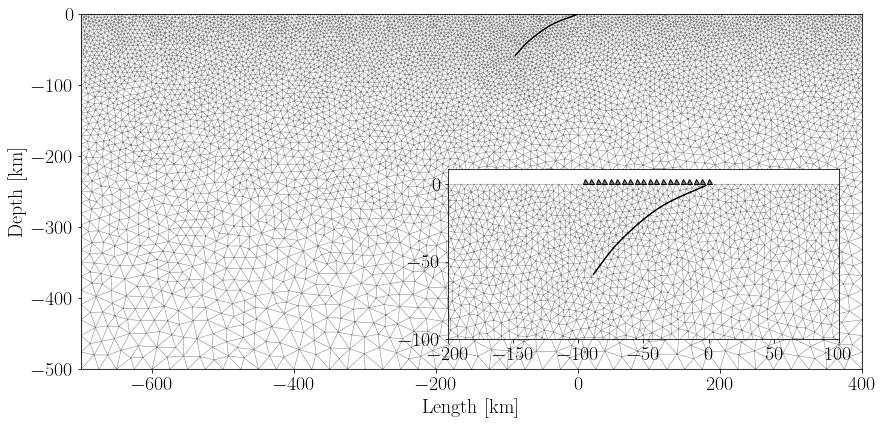

In [8]:
# Plot mesh and surface obseration locations
triang = tri.Triangulation(*mesh.coordinates().reshape((-1, 2)).T, triangles=mesh.cells())
fig, ax = plt.subplots(figsize=(14,8))
ax.set_aspect('equal')
ax.triplot(triang, lw=0.5, color='gray')
ax.plot(xf, yf, color="black")
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_xlabel("Length [km]")
ax.set_ylabel("Depth [km]")

# Make a new Axes instance [left, bottom, width, height]
axins = ax.inset_axes([0.47, 0.075, 0.5, 0.5])
axins.set_aspect('equal')
#axins.tricontourf(triang, v_x, levels=levels, cmap=cmap, extend='both')
axins.triplot(triang, lw=0.5, color='gray')
axins.plot(xf, yf, color="black")
axins.plot(targets[:,0], targets[:,1]+2, marker="^", linestyle='None',
            markersize=5, markerfacecolor="grey", markeredgecolor="black")
axins.set_xlim((-200.0, 100.0))
axins.set_ylim((-100.0, 10.0))

plt.show()

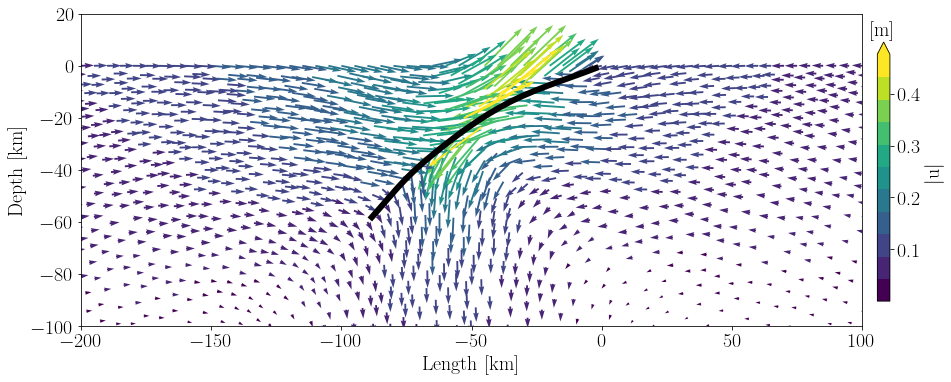

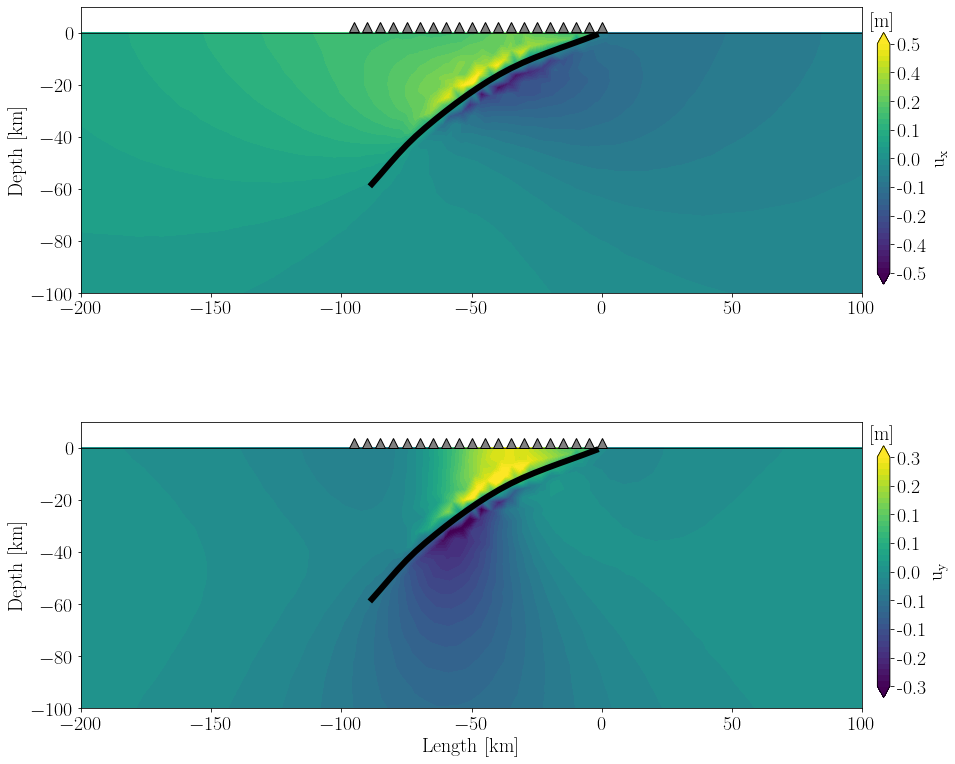

In [9]:
# Choose levels for colorbar
levels_ux = np.linspace(-0.5, 0.5, 41)
levels_uy = np.linspace(-0.3, 0.3, 41)
# Choose the colormaps
cmap = cm.get_cmap('viridis', 11)
cmap_1 = "viridis"
# Choose parameters for colorbar
left1 = 0.915; width1 = 0.0125; height1 = 0.4
left2 = 0.915; width2 = 0.0125; height2 = 0.25


# Plot FORWARD problem: displacement magnitude
fig = plt.figure(figsize=(14,9))
CS = dl.plot( dl.Function(Vh[hp.STATE].sub(1), utrue), cmap=cmap )
plt.plot(xf, yf, 'k', linewidth=6.0)
plt.xlim((-200.0, 100.0)); plt.ylim((-100.0, 20.0))
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlabel("Length [km]")
ax.set_ylabel("Depth [km]")
# left, top, width, height
cbar_ax_1 = plt.gcf().add_axes([left1, 0.3, width1, height1])
cbar = plt.colorbar(CS, cax=cbar_ax_1, orientation="vertical", format="%.1f", extend="max", label=r'$|\mathrm{u}|$')
cbar_ax_1.xaxis.set_ticks_position('top')
cbar_ax_1.xaxis.set_label_position('top')
cbar.ax.set_title('[m]')
plt.show()


# Plot FORWARD problem: displacement components (horizontal and vertical)
plt.figure(figsize=(14,14))
plt.subplot(211)
CS_x = dl.plot( dl.Function(Vh[hp.STATE].sub(1), utrue)[0], levels=levels_ux, cmap=cmap_1, extend='both' )
plt.plot(xf, yf, 'k', linewidth=6.0)
plt.plot(np.array([-200.0, 100.0]), np.array([0.0, 0.0]), color="black", linewidth=0.75)
plt.plot(targets[:,0], targets[:,1]+2, marker="^", linestyle='None', 
        markersize=10, markerfacecolor="grey", markeredgecolor="black")
plt.xlim((-200.0, 100.0)); plt.ylim((-100.0, 10.0))
ax = plt.gca()
ax.set_aspect('equal')
ax.set_ylabel("Depth [km]")
# left, top, width, height
cbar_ax_x = plt.gcf().add_axes([left2, 0.575, width2, height2])
cbar1 = plt.colorbar(CS_x, cax=cbar_ax_x, orientation="vertical", format="%.1f", label=r'$\mathrm{u_x}$')
cbar_ax_x.xaxis.set_ticks_position('top')
cbar_ax_x.xaxis.set_label_position('top')
cbar1.ax.set_title('[m]')

plt.subplot(212)
CS_y = dl.plot( dl.Function(Vh[hp.STATE].sub(1), utrue)[1], levels=levels_uy, cmap=cmap_1, extend='both' )
plt.plot(xf, yf, 'k', linewidth=6.0)
plt.plot(np.array([-200.0, 100.0]), np.array([0.0, 0.0]), color="black", linewidth=0.75)
plt.plot(targets[:,0], targets[:,1]+2, marker="^", linestyle='None', 
        markersize=10, markerfacecolor="grey", markeredgecolor="black")
plt.xlim((-200.0, 100.0)); plt.ylim((-100.0, 10.0))
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlabel("Length [km]")
ax.set_ylabel("Depth [km]")
# left, top, width, height
cbar_ax_y = plt.gcf().add_axes([left2, 0.165, width2, height2])
cbar2 = plt.colorbar(CS_y, cax=cbar_ax_y, orientation="vertical", format="%.1f", label=r'$\mathrm{u_y}$')
cbar_ax_y.xaxis.set_ticks_position('top')
cbar_ax_y.xaxis.set_label_position('top')
cbar2.ax.set_title('[m]')

plt.show()

### Plot Results of Coseismic Slip Inversion

We plot the result of the coseismic slip inversion.

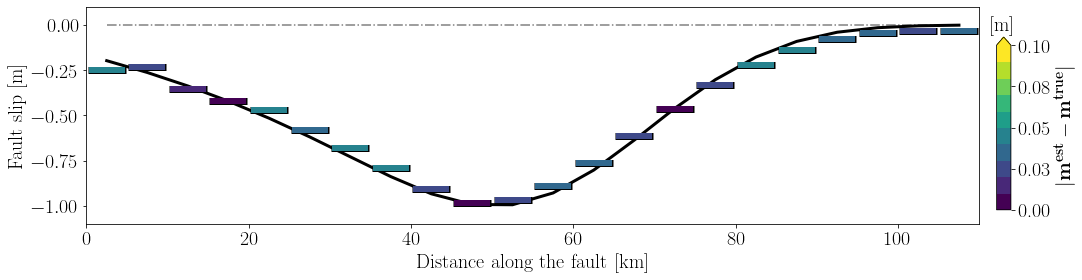

In [10]:
# Plot results of the coseismic slip inversion
fault_patch = 5 #[km]
nseg_fault = 22
width = np.linspace(0+fault_patch/2, 110-fault_patch/2, nseg_fault) 
hlen = (width[1]-width[0])/2
cmap_2 = cm.get_cmap('viridis', 10)

fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(width, np.zeros(len(width)), '-.', color="grey")
ax.plot(width, mtrue0, color="black", linestyle='solid', linewidth=3.0)
ax.scatter(width, m_slip, marker='_', color='black', s=1400, linewidth=7)
CS_m = ax.scatter(width, m_slip, c=abs(m_slip-mtrue0), cmap=cmap_2, marker='_', s=1300, 
                  linewidth=6, vmin=0., vmax=0.1, zorder=10)
ax.set_xlim(( width.min()-hlen, width.max()+hlen ))
ax.set_ylim((-1.1, 0.1))
ax.set_xlabel("Distance along the fault [km]")
ax.set_ylabel("Fault slip [m]")
# left, top, width, height
cbar_ax = plt.gcf().add_axes([left1, 0.175, width1, 0.6])
cbar = plt.colorbar(CS_m, cax=cbar_ax, orientation="vertical", extend='max', format="%.2f")
cbar.set_label(label=r'$|\mathbf{m^{est}} - \mathbf{m^{true}}|$', loc='center', rotation=90)
cbar.ax.set_title('[m]')

plt.show()

### Plot Spectrum of Hessian Misfit

We plot eigenvalues and eigenvectors of the misfit part of the Hessian $\mathbf{H}^{\text{misift}}$.

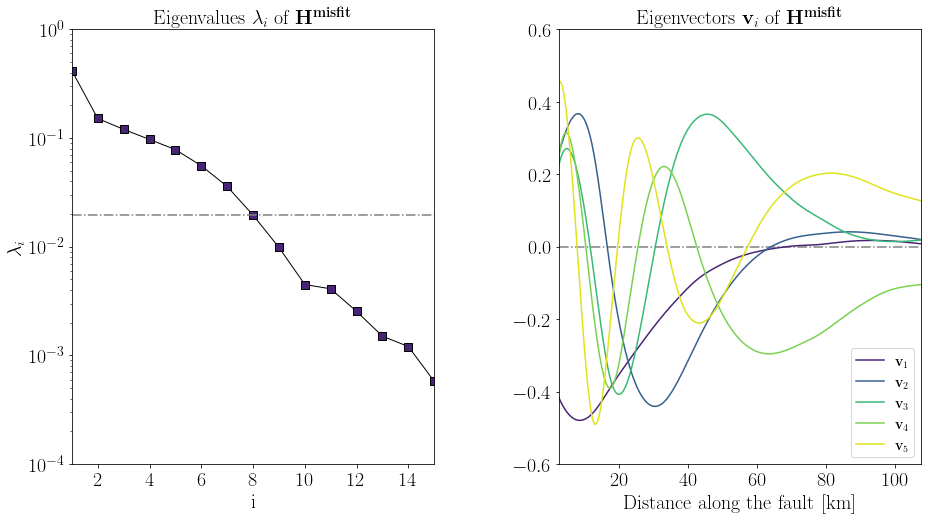

In [11]:
# Plot eigenvalues and eigenvectors of the Hessian misfit
fig, axi = plt.subplots(1,2,figsize=(16,8))
fig.subplots_adjust(hspace=0.05, wspace=0.20)
N_V = 5
p = 7
idx_FE = np.linspace(1, len(lambda_H), len(lambda_H))
# Interpolate width
width_1 = np.linspace(start=width[0], stop=width[-1], num=1000)
# Choose colors
cmap_v = cm.get_cmap('viridis')
colors_V = [cmap_v(0.1), cmap_v(0.3), cmap_v(0.675), cmap_v(0.8), cmap_v(0.95)]

ax = axi[0]
ax.semilogy(idx_FE, lambda_H, 's-', color='black', markerfacecolor=colors_V[0],
            linewidth=1.0, markersize=8.0)
ax.semilogy(idx_FE, lambda_H[p]*np.ones(len(lambda_H)), '-.', color="grey")
ax.set_xlim((1, 15))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim((1e-4, 1e0))
ax.set_xlabel("i")
ax.set_ylabel(r"$\lambda_i$")
ax.set_title(r"Eigenvalues $\lambda_i$ of $\mathbf{H^{misfit}}$")
ax.set_box_aspect(1.2)

ax = axi[1]
ax.plot(width, np.zeros(len(width)), '-.', color="grey")
for i in range(N_V):
    # Interpolate the eigevectors to make them more smooth
    V_H_interp = interpolate.InterpolatedUnivariateSpline(x=width, y=V_all[i,:], k=3)
    V_H_1 = V_H_interp(width_1)
    # Flip and multiply by -1 v_4 to resemble spectrum of G^T G (Okada)
    if i == 3:
        ax.plot(width_1, -np.flip(V_H_1), color=colors_V[i], label=r"$\mathbf{v}_{%d}$" %(i+1))
    else: 
        ax.plot(width_1, np.flip(V_H_1), color=colors_V[i], label=r"$\mathbf{v}_{%d}$" %(i+1))
ax.set_ylim((-0.6, 0.6))
ax.set_xlim( (width.min(), width.max()) )
ax.legend(loc="lower right")
ax.set_xlabel("Distance along the fault [km]")
ax.set_title(r"Eigenvectors $\mathbf{v}_i$ of $\mathbf{H^{misfit}}$")
ax.set_box_aspect(1.2)

plt.show()

## L-curve Criterion

We seek the "optimal" regularization parameter $\gamma$ by using the L-curve criterion (Miller, 1970; Lawson and Hanson, 1995).

In [12]:
### Compute L-curve criterion ###
# Solve to find the best regularization parameter by using the L-curve criterion
rho = 1e4
gammas = np.logspace(-4,6,11) 
dmisfit = []
mmisfit = []

for gamma in gammas:
    gamma = gamma*noise_variance
    delta = gamma / rho
    print('****** Computing solution with gamma = ', gamma/noise_variance, 'rho = ', rho, 'and delta = ', delta, '******')
    _, _, _, _, _, _, _, _, _, _, _, _, _, _, misfit_d, misfit_m = solve(mtrue_expr, m0_expr, ntargets, rel_noise, gamma=gamma, delta=delta, verbose=False)
    dmisfit.append(misfit_d)
    mmisfit.append(misfit_m)

****** Computing solution with gamma =  0.0001 rho =  10000.0 and delta =  1.9664188839695057e-12 ******
 Iterartion :  0  (B r, r) =  141757644.24293792
 Iteration :  1  (B r, r) =  4156467.884163787
 Iteration :  2  (B r, r) =  292987.0005361173
 Iteration :  3  (B r, r) =  39473.553461605916
 Iteration :  4  (B r, r) =  3068.4081644714315
 Iteration :  5  (B r, r) =  261.0593386273227
 Iteration :  6  (B r, r) =  164.5880578968625
 Iteration :  7  (B r, r) =  4272.73841003577
 Iteration :  8  (B r, r) =  63.30804791895581
 Iteration :  9  (B r, r) =  38.746572764941334
 Iteration :  10  (B r, r) =  205.54562548797315
 Iteration :  11  (B r, r) =  30.418291745830867
 Iteration :  12  (B r, r) =  185.40763953982906
 Iteration :  13  (B r, r) =  5.7722752844590985
 Iteration :  14  (B r, r) =  46.91382467942287
 Iteration :  15  (B r, r) =  2.0044962677022875
 Iteration :  16  (B r, r) =  77.44398707545534
 Iteration :  17  (B r, r) =  12.373208076993528
 Iteration :  18  (B r, r) =  1

 Iteration :  166  (B r, r) =  0.05873866584150778
 Iteration :  167  (B r, r) =  2.8020974757451995
 Iteration :  168  (B r, r) =  0.9009912339600608
 Iteration :  169  (B r, r) =  0.06909959390926516
 Iteration :  170  (B r, r) =  0.3915590604451855
 Iteration :  171  (B r, r) =  0.0305298628041073
 Iteration :  172  (B r, r) =  0.9403749831974731
 Iteration :  173  (B r, r) =  0.15900582613523445
 Iteration :  174  (B r, r) =  45.18529807794623
 Iteration :  175  (B r, r) =  0.4663300720534929
 Iteration :  176  (B r, r) =  0.2737824966398521
 Iteration :  177  (B r, r) =  0.09061044289190914
 Iteration :  178  (B r, r) =  1.059292733104472
 Iteration :  179  (B r, r) =  0.719802091105441
 Iteration :  180  (B r, r) =  0.04407081836283331
 Iteration :  181  (B r, r) =  0.03212660125412045
 Iteration :  182  (B r, r) =  0.1447984187643362
 Iteration :  183  (B r, r) =  16.89697329267631
 Iteration :  184  (B r, r) =  2.37719097038441
 Iteration :  185  (B r, r) =  0.00280880096092234

 Iteration :  325  (B r, r) =  5.206419480244895e-08
 Iteration :  326  (B r, r) =  1.2801992991846576e-06
 Iteration :  327  (B r, r) =  4.3467507180782865e-08
 Iteration :  328  (B r, r) =  8.387299085940156e-08
 Iteration :  329  (B r, r) =  6.36440380830791e-05
 Iteration :  330  (B r, r) =  1.1660763760541316e-06
 Iteration :  331  (B r, r) =  1.3257789904442682e-06
 Iteration :  332  (B r, r) =  7.330236709816406e-08
 Iteration :  333  (B r, r) =  1.57002638687276e-08
 Iteration :  334  (B r, r) =  8.529077379089936e-08
 Iteration :  335  (B r, r) =  1.1546443672667123e-07
 Iteration :  336  (B r, r) =  2.9067993214747205e-08
 Iteration :  337  (B r, r) =  1.3218556669928851e-05
 Iteration :  338  (B r, r) =  4.991898929179955e-06
 Iteration :  339  (B r, r) =  7.2373117539191975e-06
 Iteration :  340  (B r, r) =  4.263330232911387e-07
 Iteration :  341  (B r, r) =  7.302399801029015e-08
 Iteration :  342  (B r, r) =  1.869918108549259e-06
 Iteration :  343  (B r, r) =  1.3631907

 Iteration :  481  (B r, r) =  2.5398185804457746e-09
 Iteration :  482  (B r, r) =  1.1427697100909178e-08
 Iteration :  483  (B r, r) =  2.193510524705351e-10
 Iteration :  484  (B r, r) =  1.243246377834637e-09
 Iteration :  485  (B r, r) =  5.62634689372282e-11
 Iteration :  486  (B r, r) =  6.289473914840658e-10
 Iteration :  487  (B r, r) =  9.963275983451562e-09
 Iteration :  488  (B r, r) =  2.412817834426679e-10
 Iteration :  489  (B r, r) =  7.392551151356726e-10
 Iteration :  490  (B r, r) =  2.2352971842680098e-09
 Iteration :  491  (B r, r) =  1.7065043574312748e-09
 Iteration :  492  (B r, r) =  1.0228384291257941e-12
 Iteration :  493  (B r, r) =  6.397359811263269e-13
 Iteration :  494  (B r, r) =  1.115141897037278e-12
 Iteration :  495  (B r, r) =  1.6999665753214806e-12
 Iteration :  496  (B r, r) =  1.3071077548247513e-13
 Iteration :  497  (B r, r) =  1.695308074080708e-14
 Iteration :  498  (B r, r) =  4.3929135909046544e-13
 Iteration :  499  (B r, r) =  8.538188

 Iteration :  65  (B r, r) =  0.24939407902831312
 Iteration :  66  (B r, r) =  0.35299280103256153
 Iteration :  67  (B r, r) =  0.143997654493632
 Iteration :  68  (B r, r) =  0.42185279256155495
 Iteration :  69  (B r, r) =  6.19087699643777
 Iteration :  70  (B r, r) =  0.05093073909485211
 Iteration :  71  (B r, r) =  1.133309043009152
 Iteration :  72  (B r, r) =  0.0013838984187920975
 Iteration :  73  (B r, r) =  0.07123425254256928
 Iteration :  74  (B r, r) =  0.05393758567830914
 Iteration :  75  (B r, r) =  0.03806324660869484
 Iteration :  76  (B r, r) =  0.17464470661483653
 Iteration :  77  (B r, r) =  0.086066079886982
 Iteration :  78  (B r, r) =  0.5586738324666642
 Iteration :  79  (B r, r) =  0.03968038923653268
 Iteration :  80  (B r, r) =  0.03753146661863616
 Iteration :  81  (B r, r) =  0.7498738305831016
 Iteration :  82  (B r, r) =  0.03470855730072425
 Iteration :  83  (B r, r) =  0.0017989571126564249
 Iteration :  84  (B r, r) =  0.0003185152603399881
 Iter

 Iteration :  222  (B r, r) =  6.34301667645083e-09
 Iteration :  223  (B r, r) =  1.0448302830181227e-09
 Iteration :  224  (B r, r) =  1.8892214477458974e-07
 Iteration :  225  (B r, r) =  1.914076903311275e-07
 Iteration :  226  (B r, r) =  2.0409977121002726e-09
 Iteration :  227  (B r, r) =  1.439527004352427e-10
 Iteration :  228  (B r, r) =  1.9465663822039027e-10
 Iteration :  229  (B r, r) =  4.268115521479779e-08
 Iteration :  230  (B r, r) =  2.7821029565031997e-10
 Iteration :  231  (B r, r) =  2.9221160247313087e-10
 Iteration :  232  (B r, r) =  1.3891850737709057e-09
 Iteration :  233  (B r, r) =  1.4135506013571415e-09
 Iteration :  234  (B r, r) =  3.3823296402722254e-11
 Iteration :  235  (B r, r) =  1.084284955967153e-09
 Iteration :  236  (B r, r) =  4.675900045800535e-09
 Iteration :  237  (B r, r) =  2.490973386848265e-09
 Iteration :  238  (B r, r) =  1.8346045039974846e-09
 Iteration :  239  (B r, r) =  1.1718566735293977e-09
 Iteration :  240  (B r, r) =  2.083

 Iteration :  18  (B r, r) =  0.010173207539176485
 Iteration :  19  (B r, r) =  0.0565046682758229
 Iteration :  20  (B r, r) =  0.5588109441372142
 Iteration :  21  (B r, r) =  0.054415121832186206
 Iteration :  22  (B r, r) =  0.7986637470792175
 Iteration :  23  (B r, r) =  0.38112001621495095
 Iteration :  24  (B r, r) =  0.06462318041655954
 Iteration :  25  (B r, r) =  0.06216455242917054
 Iteration :  26  (B r, r) =  3.3299696193903725
 Iteration :  27  (B r, r) =  0.020249140119531522
 Iteration :  28  (B r, r) =  7.434459409740938
 Iteration :  29  (B r, r) =  0.6098051398051332
 Iteration :  30  (B r, r) =  0.6261776643623481
 Iteration :  31  (B r, r) =  0.009237305828518469
 Iteration :  32  (B r, r) =  0.6168947863460519
 Iteration :  33  (B r, r) =  2.2124171148152123
 Iteration :  34  (B r, r) =  0.23394984322103612
 Iteration :  35  (B r, r) =  0.3197155405843638
 Iteration :  36  (B r, r) =  0.5752073580812316
 Iteration :  37  (B r, r) =  0.0015435931574752425
 Itera

 Iteration :  176  (B r, r) =  8.74696263315912e-15
 Iteration :  177  (B r, r) =  3.2492218982215623e-13
 Iteration :  178  (B r, r) =  1.9609210223872298e-13
 Iteration :  179  (B r, r) =  4.2712098962130135e-14
 Iteration :  180  (B r, r) =  2.972990356422232e-14
 Iteration :  181  (B r, r) =  2.3060238198807744e-15
 Iteration :  182  (B r, r) =  3.946003411036777e-17
 Iteration :  183  (B r, r) =  9.341348857437842e-16
 Iteration :  184  (B r, r) =  1.3672576373960198e-13
 Iteration :  185  (B r, r) =  7.612200489869344e-13
 Iteration :  186  (B r, r) =  1.612430302783062e-15
 Iteration :  187  (B r, r) =  3.904491450746972e-16
 Iteration :  188  (B r, r) =  1.3413374976765566e-19
Relative/Absolute residual less than tol
Converged in  188  iterations with final norm  3.662427470512633e-10
Total cost 0.0119541; Reg Cost 0.00024945; Misfit 0.0117047
****** Computing solution with gamma =  0.1 rho =  10000.0 and delta =  1.9664188839695056e-09 ******
 Iterartion :  0  (B r, r) =  1417

 Iteration :  20  (B r, r) =  8.34918163238449e-05
 Iteration :  21  (B r, r) =  8.82884067264604e-06
 Iteration :  22  (B r, r) =  7.493497783054493e-06
 Iteration :  23  (B r, r) =  1.611273467466441e-05
 Iteration :  24  (B r, r) =  7.226792766390438e-07
 Iteration :  25  (B r, r) =  8.704842111228043e-07
 Iteration :  26  (B r, r) =  5.699740229298929e-07
 Iteration :  27  (B r, r) =  5.2594748527068165e-08
 Iteration :  28  (B r, r) =  1.525525875354731e-06
 Iteration :  29  (B r, r) =  1.1663418618512853e-06
 Iteration :  30  (B r, r) =  4.473799971566784e-07
 Iteration :  31  (B r, r) =  1.6614703091918445e-09
 Iteration :  32  (B r, r) =  1.7162729683782765e-07
 Iteration :  33  (B r, r) =  2.965010162881537e-08
 Iteration :  34  (B r, r) =  2.1828067423051393e-08
 Iteration :  35  (B r, r) =  1.86319442032101e-08
 Iteration :  36  (B r, r) =  2.9546011549453113e-08
 Iteration :  37  (B r, r) =  1.8104475594373233e-11
 Iteration :  38  (B r, r) =  5.187765183386789e-11
 Iterati

Total cost 0.626695; Reg Cost 0.0558812; Misfit 0.570813
****** Computing solution with gamma =  1000000.0 rho =  10000.0 and delta =  0.01966418883969506 ******
 Iterartion :  0  (B r, r) =  0.014175764424294003
 Iteration :  1  (B r, r) =  6.530742777933404e-08
 Iteration :  2  (B r, r) =  2.0293660485540162e-14
 Iteration :  3  (B r, r) =  2.3886636586528957e-21
 Iteration :  4  (B r, r) =  7.335145051203786e-29
Relative/Absolute residual less than tol
Converged in  4  iterations with final norm  8.564546135787807e-15
Total cost 0.682616; Reg Cost 0.0069114; Misfit 0.675705


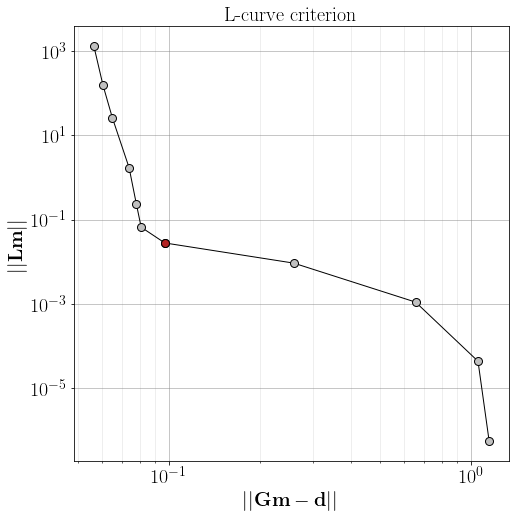

In [13]:
### L-curve criterion ###
color_L = ['silver', 'firebrick']
# Plot L-curve
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_xlabel(r"$||\mathbf{Gm} - \mathbf{d}||$")
ax.set_ylabel(r"$||\mathbf{Lm}||$")
ax.set_title("L-curve criterion")

ax.loglog(dmisfit, mmisfit, 'o-', color='black', markerfacecolor=color_L[0],
            linewidth=1.0, markersize=8.0)
ax.loglog(dmisfit[6], mmisfit[6], 'o', markerfacecolor=color_L[1],
            markeredgecolor='black', markersize=8.0)
ax.grid( b=True, which='major', color='#888888', linestyle='-', alpha=0.6 )
ax.grid( b=True, which='minor', color='#999999', linestyle='-', alpha=0.2 )
ax.set_box_aspect(1)
    
plt.show()